In [4]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential,Model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization,MaxPooling2D,Conv2D,Input,Activation
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.optimizers import Adam

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

2024-02-05 16:53:43.418484: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 16:53:43.418590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 16:53:43.536747: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
Ravdess="/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [6]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
        
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [7]:
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


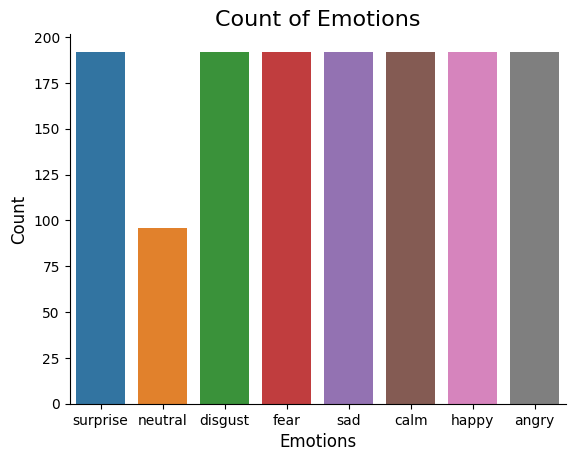

In [8]:
plt.title('Count of Emotions', size=16)
sns.countplot(x=data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [9]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)

    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

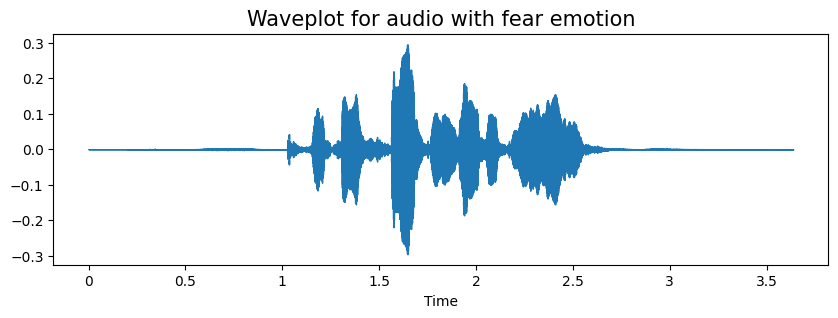

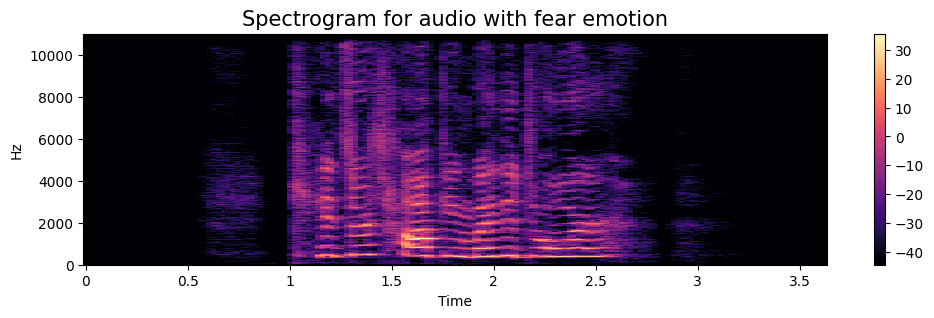

In [10]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [11]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)


In [12]:
sample_rate

22050

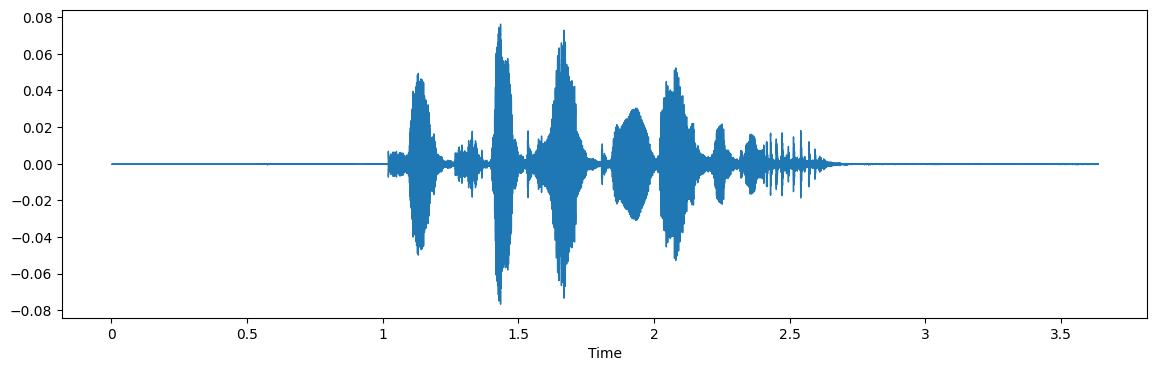

In [13]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

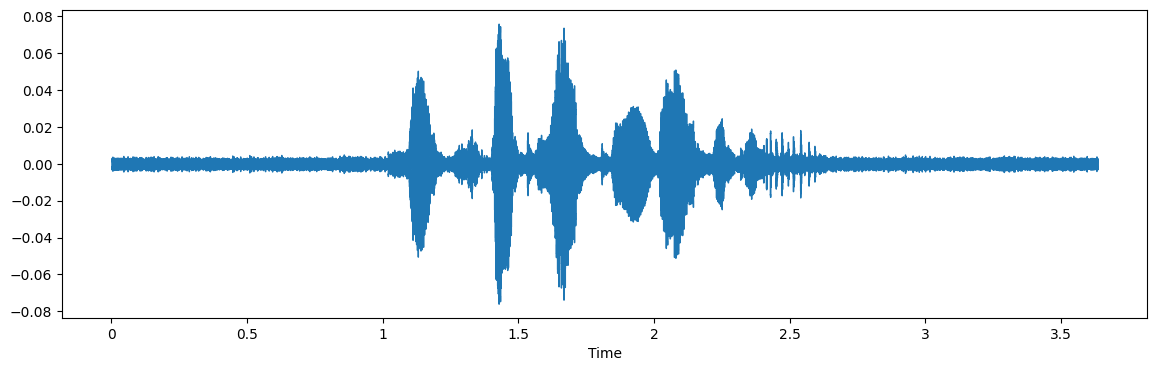

In [14]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [15]:
def extract_features(data):
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) 

    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 

    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) 

    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) 
    
    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    res1 = extract_features(data)
    result = np.array(res1)
    
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) 

    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) 
    
    return result

In [16]:

X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [17]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

In [18]:
len(X[0])

162

In [19]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.237382,0.682273,0.670519,0.614793,0.579039,0.566803,0.637206,0.667451,0.663883,0.669903,...,0.000234,0.000235,0.000138,0.000128,0.000299,0.000360,0.000275,0.000173,2.896729e-05,surprise
1,0.328758,0.729803,0.743533,0.727124,0.717218,0.743470,0.710144,0.702688,0.683382,0.710557,...,0.001178,0.001238,0.001064,0.001127,0.001388,0.001328,0.001198,0.001146,1.012514e-03,surprise
2,0.185699,0.701609,0.669991,0.646497,0.569470,0.522184,0.620172,0.694164,0.706134,0.679070,...,0.000047,0.000049,0.000054,0.000048,0.000024,0.000053,0.000074,0.000031,2.444069e-06,surprise
3,0.256113,0.621621,0.580278,0.598515,0.628296,0.598014,0.597272,0.650352,0.698635,0.681863,...,0.000018,0.000016,0.000013,0.000012,0.000007,0.000008,0.000008,0.000005,5.802854e-07,neutral
4,0.306699,0.677174,0.678822,0.725336,0.745834,0.716145,0.653998,0.691835,0.730185,0.720773,...,0.000139,0.000127,0.000136,0.000131,0.000130,0.000126,0.000132,0.000129,1.218690e-04,neutral


In [20]:
Features

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.237382,0.682273,0.670519,0.614793,0.579039,0.566803,0.637206,0.667451,0.663883,0.669903,...,0.000234,0.000235,0.000138,0.000128,0.000299,0.000360,0.000275,0.000173,2.896729e-05,surprise
1,0.328758,0.729803,0.743533,0.727124,0.717218,0.743470,0.710144,0.702688,0.683382,0.710557,...,0.001178,0.001238,0.001064,0.001127,0.001388,0.001328,0.001198,0.001146,1.012514e-03,surprise
2,0.185699,0.701609,0.669991,0.646497,0.569470,0.522184,0.620172,0.694164,0.706134,0.679070,...,0.000047,0.000049,0.000054,0.000048,0.000024,0.000053,0.000074,0.000031,2.444069e-06,surprise
3,0.256113,0.621621,0.580278,0.598515,0.628296,0.598014,0.597272,0.650352,0.698635,0.681863,...,0.000018,0.000016,0.000013,0.000012,0.000007,0.000008,0.000008,0.000005,5.802854e-07,neutral
4,0.306699,0.677174,0.678822,0.725336,0.745834,0.716145,0.653998,0.691835,0.730185,0.720773,...,0.000139,0.000127,0.000136,0.000131,0.000130,0.000126,0.000132,0.000129,1.218690e-04,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,0.286391,0.637836,0.695092,0.731892,0.782003,0.775735,0.692537,0.658671,0.663235,0.710859,...,0.002102,0.001991,0.002411,0.003268,0.003290,0.002809,0.002582,0.001353,2.407163e-04,disgust
4316,0.209086,0.543239,0.543649,0.616387,0.620218,0.661716,0.627830,0.593298,0.601903,0.625604,...,0.000419,0.000513,0.000388,0.000415,0.000393,0.000604,0.000472,0.000435,3.370507e-05,disgust
4317,0.148537,0.656566,0.652982,0.634403,0.652929,0.608521,0.557056,0.550457,0.628574,0.665743,...,0.014213,0.015852,0.012141,0.011468,0.008031,0.010061,0.015541,0.008099,5.346318e-04,angry
4318,0.334681,0.759573,0.771735,0.788315,0.808833,0.787132,0.671865,0.642723,0.706684,0.712731,...,0.076023,0.077778,0.080971,0.081007,0.072738,0.079377,0.079774,0.073148,6.395164e-02,angry


In [21]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [22]:
X

array([[2.37381547e-01, 6.82273209e-01, 6.70518875e-01, ...,
        2.74813152e-04, 1.72674409e-04, 2.89672880e-05],
       [3.28757957e-01, 7.29802858e-01, 7.43533123e-01, ...,
        1.19820035e-03, 1.14643014e-03, 1.01251378e-03],
       [1.85698785e-01, 7.01609492e-01, 6.69990957e-01, ...,
        7.36232614e-05, 3.07159789e-05, 2.44406920e-06],
       ...,
       [1.48536965e-01, 6.56565607e-01, 6.52982056e-01, ...,
        1.55405561e-02, 8.09876248e-03, 5.34631836e-04],
       [3.34680628e-01, 7.59573493e-01, 7.71735434e-01, ...,
        7.97739598e-02, 7.31480261e-02, 6.39516440e-02],
       [1.73039641e-01, 6.12223566e-01, 6.51004255e-01, ...,
        1.88611657e-03, 1.04483648e-03, 1.48691310e-04]])

In [23]:
Y

array(['surprise', 'surprise', 'surprise', ..., 'angry', 'angry', 'angry'],
      dtype=object)

In [24]:
len(Y)

4320

In [25]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [26]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0,test_size=0.3, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3024, 162), (3024, 8), (1296, 162), (1296, 8))

In [27]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3024, 162), (3024, 8), (1296, 162), (1296, 8))

In [28]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3024, 162, 1), (3024, 8), (1296, 162, 1), (1296, 8))

In [ ]:
def Convolution(input_tensor,filters,kernel_size):
    x=Conv1D(filters=filters,kernel_size=kernel_size,padding="same")(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=MaxPooling1D(pool_size=5)(x)
    x=Dropout(0.25)(x)
    
    return x

    
    

In [ ]:
def Dense_f(input_tensor,nodes):
    x=Dense(nodes)(input_tensor)
    
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Dropout(0.25)(x)
    
    return x

    
    

In [35]:
def model_fer(input_shape):
    inputs=Input(input_shape)
    conv_1=Convolution(inputs,64,(5))
    conv_2=Convolution(conv_1,128,(5))
    conv_3=Convolution(conv_2,256,(5))
    conv_4=Convolution(conv_3,512,(5))
    
    flatten=Flatten()(conv_4)
    
    dense_1=Dense_f(flatten,256)
    dense_2=Dense_f(dense_1,512)
    
    output=Dense(units=8,activation="softmax")(dense_2)
    model=Model(inputs=[inputs],outputs=[output])
    opt=Adam(lr=0.0005)
    model.compile(loss=['categorical_crossentropy'],optimizer=opt,metrics=['accuracy'])
    
    return model

In [36]:
X.shape

(4320, 162)

In [37]:
model=model_fer(((162),1))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 162, 1)]          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 162, 64)           384       
                                                                 
 batch_normalization_6 (Bat  (None, 162, 64)           256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 162, 64)           0         
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 81, 64)            0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 81, 64)            0   

In [38]:
checkpoint=ModelCheckpoint('model_weights.h5',monitor='accuracy',save_weights_only=True,mode='max',verbose=0)

rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
callbacks=[checkpoint,rlrp]
history=model.fit(x_train, y_train, batch_size=64, epochs=250, validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/250


I0000 00:00:1707152786.440953     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 10s 30ms/step - loss: 2.0413 - accuracy: 0.2226 - val_loss: 2.0303 - val_accuracy: 0.1759 - lr: 0.0010
Epoch 2/250
48/48 [==============================] - 1s 14ms/step - loss: 1.8173 - accuracy: 0.3237 - val_loss: 2.0242 - val_accuracy: 0.1991 - lr: 0.0010
Epoch 3/250
48/48 [==============================] - 1s 13ms/step - loss: 1.7391 - accuracy: 0.3456 - val_loss: 2.0037 - val_accuracy: 0.1543 - lr: 0.0010
Epoch 4/250
48/48 [==============================] - 1s 14ms/step - loss: 1.6663 - accuracy: 0.3704 - val_loss: 2.0987 - val_accuracy: 0.1605 - lr: 0.0010
Epoch 5/250
48/48 [==============================] - 1s 13ms/step - loss: 1.5973 - accuracy: 0.3915 - val_loss: 1.9732 - val_accuracy: 0.2446 - lr: 0.0010
Epoch 6/250
48/48 [==============================] - 1s 14ms/step - loss: 1.5151 - accuracy: 0.4282 - val_loss: 1.9255 - val_accuracy: 0.2562 - lr: 0.0010
Epoch 7/250
48/48 [==============================] - 1s 14ms/step - loss: 1.4418 

41/41 [==============================] - 0s 4ms/step - loss: 0.4988 - accuracy: 0.8426
Accuracy of our model on test data :  84.25925970077515 %


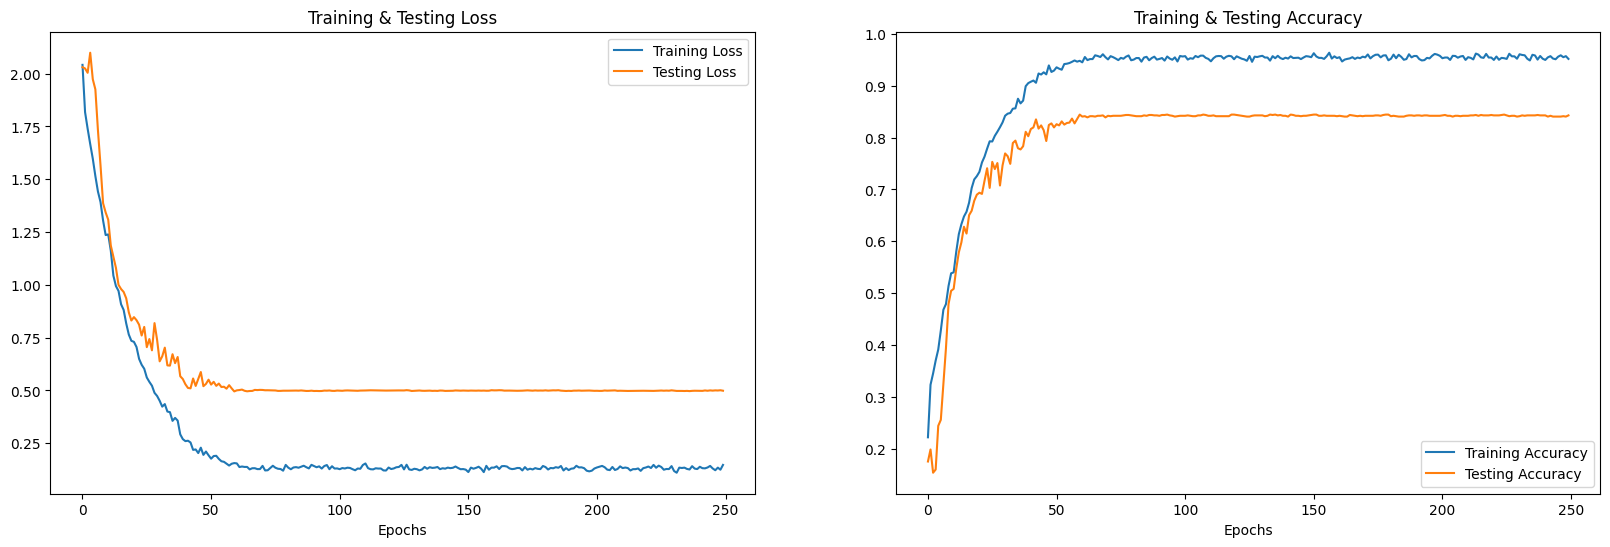

In [39]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")
epochs = [i for i in range(250)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [40]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

41/41 [==============================] - 0s 3ms/step


In [41]:
y_pred[0]

array(['fear'], dtype=object)

In [42]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,fear
1,neutral,neutral
2,disgust,sad
3,neutral,neutral
4,fear,fear
5,angry,angry
6,fear,fear
7,fear,fear
8,disgust,disgust
9,calm,calm


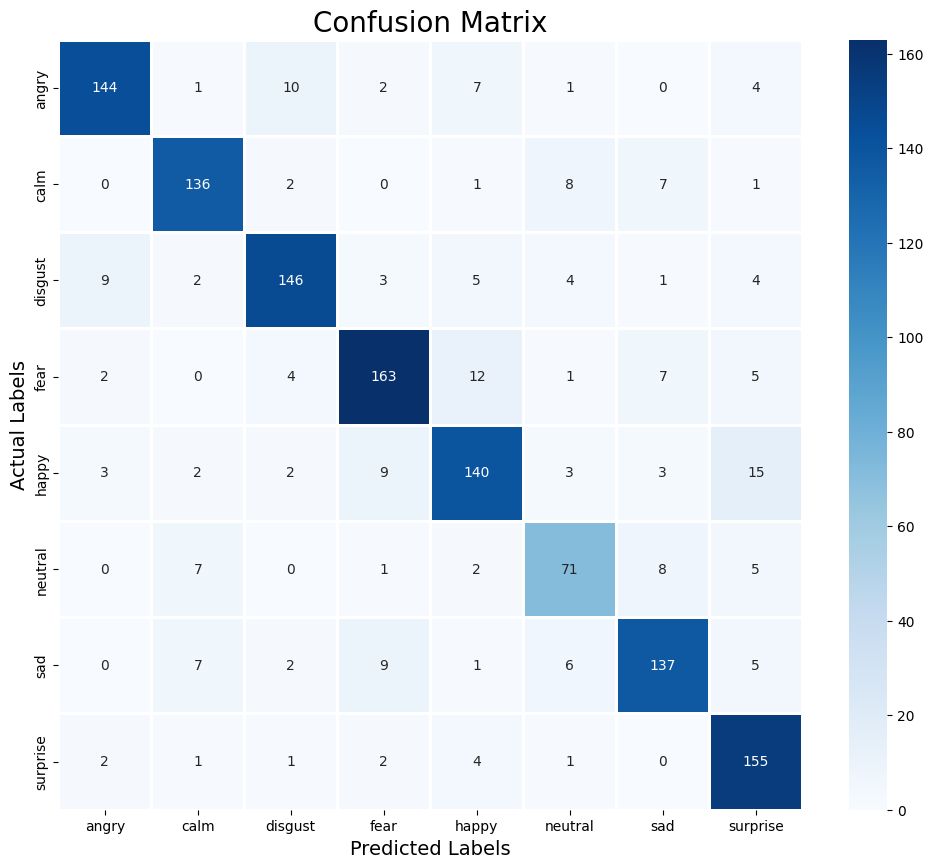

In [43]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [44]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       angry       0.90      0.85      0.88       169
        calm       0.87      0.88      0.87       155
     disgust       0.87      0.84      0.86       174
        fear       0.86      0.84      0.85       194
       happy       0.81      0.79      0.80       177
     neutral       0.75      0.76      0.75        94
         sad       0.84      0.82      0.83       167
    surprise       0.80      0.93      0.86       166

    accuracy                           0.84      1296
   macro avg       0.84      0.84      0.84      1296
weighted avg       0.84      0.84      0.84      1296



In [45]:
json_file=model.to_json()

In [46]:
with open('model.json','w') as file:
    file.write(json_file)